In [20]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph,START,END
from typing import TypedDict,List
import os
from dotenv import load_dotenv
load_dotenv()
import pandas as pd

In [21]:
df = pd.read_csv("customer_support_tickets.csv")

In [22]:
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

In [23]:
class SupportState(TypedDict):
  input: str
  history:List[str]
  output:str
  

In [24]:
def route(state:SupportState)->str:
  user_input = state['input'].lower()
  if "bill" in user_input or "payment" in user_input:
    return "billing_node"
  elif "not working" in user_input or "error" in user_input:
    return "tech_node"
  elif "order" in user_input or "tracking" in user_input:
    return "order_node"
  else:
    return "fallback_node"


In [25]:
def billing_node(state:SupportState) -> SupportState:
  prompt = "you are a customer support bot write a reply for billing query"
  response = llm.invoke(prompt).content
  state["output"] = response
  return state
  
def tech_node(state: SupportState):
    prompt = "you are a customer support bot write a reply for Technical problem"
    response = llm.invoke(prompt).content
    state["output"] = response
    return state

def order_node(state: SupportState):
    prompt = "you are a customer support bot write a reply for order query"
    response = llm.invoke(prompt).content
    state["output"] = response
    return state

def fallback_node(state: SupportState):
    response = "Can you please clarify your issue?"
    state["output"] = response
    return state


In [26]:
graph = StateGraph(SupportState)

graph.add_node("billing_node",billing_node)
graph.add_node("tech_node",tech_node)
graph.add_node("order_node",order_node)
graph.add_node("fallback_node",fallback_node)
graph.set_entry_point("route")

graph.add_conditional_edges("route",route,{
  "billing_node":"billing_node",
  "tech_node":"tech_node",
  "order_node":"order_node",
  "fallback_node":"fallback_node"
})
graph.add_edge("billing_node", END)
graph.add_edge("tech_node", END)
graph.add_edge("order_node", END)
graph.add_edge("fallback_node", END)

graph.add_node("route", lambda state: state)

app = graph.compile()

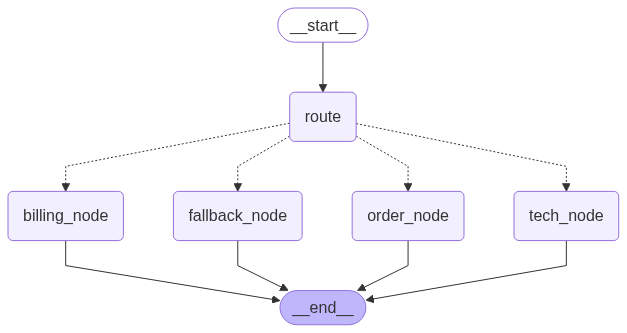

In [27]:
from IPython.display import display,Image
display(Image(app.get_graph().draw_mermaid_png()))

In [29]:
state = {"input": "I want to track my order", "history": []}
result = app.invoke(state)
print(result["output"])

Hi there! Thanks for reaching out.  I'd be happy to help with your order query. To assist you best, could you please provide me with your order number?  Once I have that, I can quickly access your order details and answer your questions.
